In [9]:
# -*- coding: utf-8 -*-
# Copyright (c) 2015 Lynn Root

import datetime
import json
import os

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

## Load Data for PyLadies and their local Python User Groups

In [42]:
DATA_DIR = "meetup_data"
MEMBER_JSON = "pug_members.json"
GROUP_DIRS = [d for d in os.listdir(DATA_DIR)]
PYLADIES_GROUPS = []
for group in GROUP_DIRS:
    if os.path.isdir(os.path.join(DATA_DIR, group)):
        PYLADIES_GROUPS.append(group)

In [50]:
def load_group_data(pyladies_group):
    pyladies_dir = os.path.join(DATA_DIR, pyladies_group)
    members_json = os.path.join(pyladies_dir, MEMBER_JSON)
    with open(members_json, "r") as f:
        return json.load(f)

#### Get date for when the PyLadies group was started

In [58]:
def pyladies_created(pyladies_group):
    pyladies_dir = os.path.join(DATA_DIR, pyladies_group)
    pyladies_file = os.path.join(pyladies_dir, pyladies_group + ".json")
    with open(pyladies_file, "r") as f:
        data = json.load(f)
    created_ms = data.get("created")  # in ms after epoch
    created_s = created_ms / 1000
    created = datetime.datetime.fromtimestamp(created_s)
    year = created.strftime('%Y')
    month = created.strftime('%m')
    day = created.strftime('%d')
    return year, month, day

## Create some dataframes in Pandas

**WARNING** I do not know how to properly panda.  This is my hacky attempt.

In [72]:
# helper function to create a dataframe out of multiple data frames
# one DF per PUG
def _create_dataframe(group, data):
    df = pd.read_json(json.dumps(data))
    joined = df.loc[:,("id", "joined")]
    joined["joined"] = df.joined.apply(lambda x: pd.to_datetime([x], unit="ms"))
    joined["mon"] = joined.joined.apply(lambda x: x.month[0])
    joined["year"] = joined.joined.apply(lambda x: x.year[0])
    agg_joined = joined.groupby(["year", "mon"]).count()
    return agg_joined

In [70]:
def collect_dataframes(group_data):
    dfs = []
    for group in group_data.keys():
        data = group_data.get(group)[0]
        df = _create_dataframe(group, data)
        tmp = {}
        tmp[group] = df
        dfs.append(tmp)
    return dfs

In [21]:
# aggregate dataframes, name columns nicely, etc
def aggregate_dataframes(dfs):
    first = dfs.pop(0)
    name = first.keys()[0]
    _df = first.values()[0]
    df = _df.loc[:, ("id", "joined")]  # multi indices are hard.
    df.rename(columns={"joined": name}, inplace=True)
    for d in dfs:
        name = d.keys()[0]
        _df = d.values()[0]
        df[name] = _df["joined"]
        df = df.fillna(0)
    df.drop('id', axis=1, inplace=True)
    return df

## Now let's graph

In [22]:
# helper function for x-axis labels
def _get_x_axis(current):
    updated = []
    for item in current:
        _date = item.get_text()  # u'(2009, 2)'
        if _date == "":
            updated.append(_date)
        else:
            _date = _date.strip("(").strip(")").split(",")  # [u'2009', u' 2']  # NOQA
            _date = [d.strip() for d in _date]  # [2009, 2]
            label = "{0}-{1}".format(_date[1], _date[0])
            updated.append(label)
    return updated

In [24]:
# helper function to plot created date annotation
def _created_xy(df, created):
    year, month, _ = created
    indexlist = df.index.tolist()
    created_index = indexlist.index((int(year), int(month)))
    return created_index

In [89]:
# helper function to position the annotated text
def _find_max(df, groups):
    maxes = [df[g].max() for g in groups]
    return max(maxes)

In [93]:
def create_graph(df, pyladies, created, groups):
    created = _created_xy(df, created)
    created_yarrow = int(round(_find_max(df, groups) * .80))
    created_ylabel = int(round(created_yarrow * .80))

    graph = df.plot(figsize=(17, 8), linewidth=4)
    graph.set_title(pyladies)
    xlabels = _get_x_axis(graph.get_xticklabels())
    graph.set_xticklabels(xlabels, rotation=45)
    graph.set_xlabel("Month")
    graph.set_ylabel("# of members joined")
    for i, line in enumerate(graph.get_lines()):
        line.set_linewidth(3)
    graph.legend()  # update legend with line weight changes
    graph.axvline(x=created, ymin=0.0, ymax=1.0, linewidth=4)
    graph.annotate("PyLadies Created", (created, created_yarrow),
                   xytext=(created - 8, created_ylabel), xycoords="data",
                   arrowprops=dict(arrowstyle="->", facecolor='black', linewidth=3))
    # needs `%matplotlib inline`
    plt.show()
    
    # if you'd rather save the graph as an image locally
    # output = os.path.join(self.pyladies_dir, pyladies + ".png")
    # plt.savefig(output, dpi=300)

## To put it all together now

I'm only going to do a handful, not all the groups.  But this should give you an idea.

Also - some shit breaks. Surely I'll fix it in my Copious Amount of Free Time™ :D

In [28]:
%matplotlib inline

In [95]:
def create_pyladies_graph(pyladies):
    group_data = load_group_data(pyladies)
    created = pyladies_created(pyladies)
    dfs = collect_dataframes(group_data)
    df = aggregate_dataframes(dfs)
    create_graph(df, pyladies, created, group_data.keys())

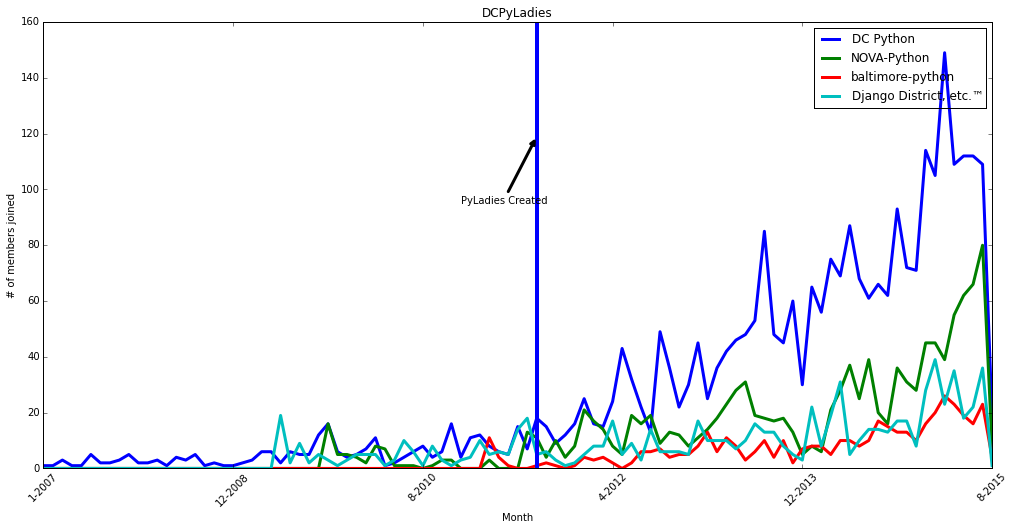

In [98]:
create_pyladies_graph(PYLADIES_GROUPS[2])

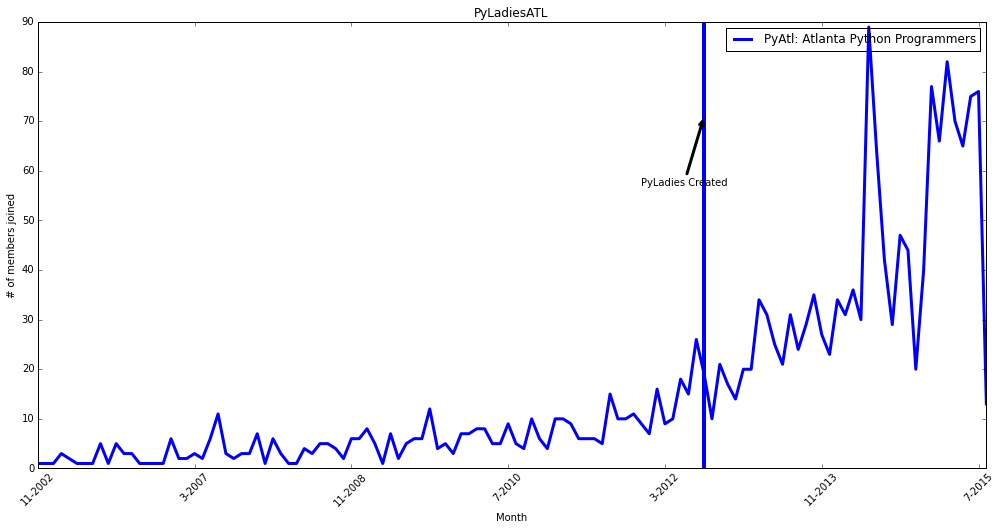

In [107]:
create_pyladies_graph(PYLADIES_GROUPS[11])

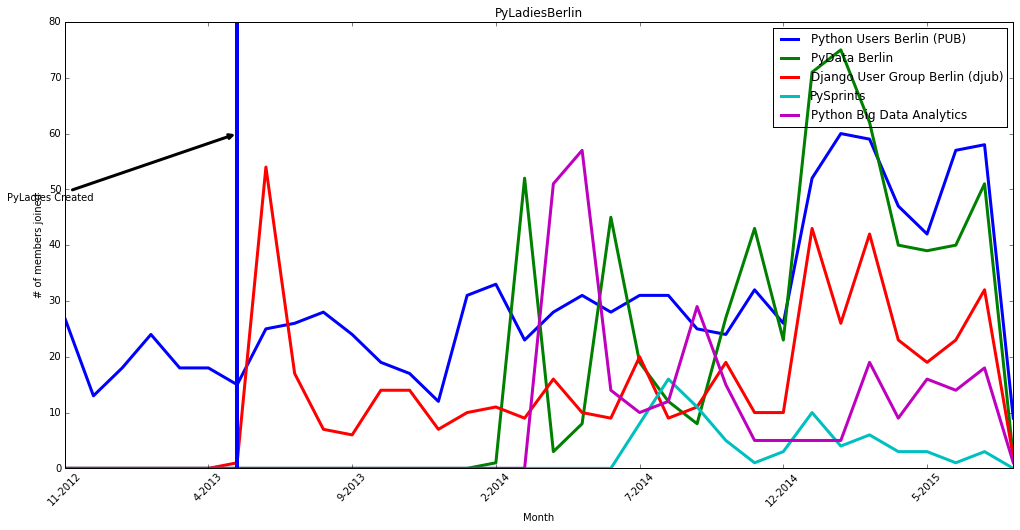

In [110]:
create_pyladies_graph(PYLADIES_GROUPS[14])

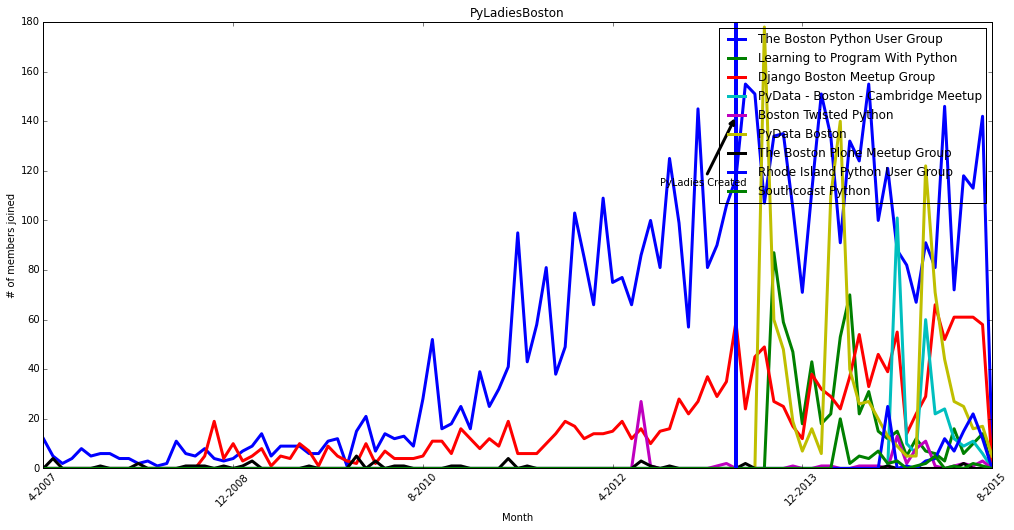

In [111]:
create_pyladies_graph(PYLADIES_GROUPS[15])

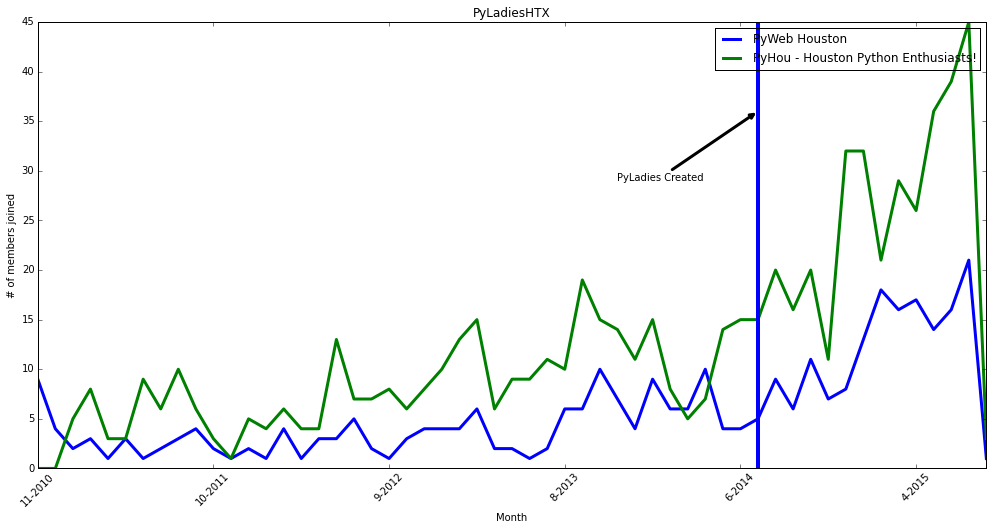

In [115]:
create_pyladies_graph(PYLADIES_GROUPS[19])

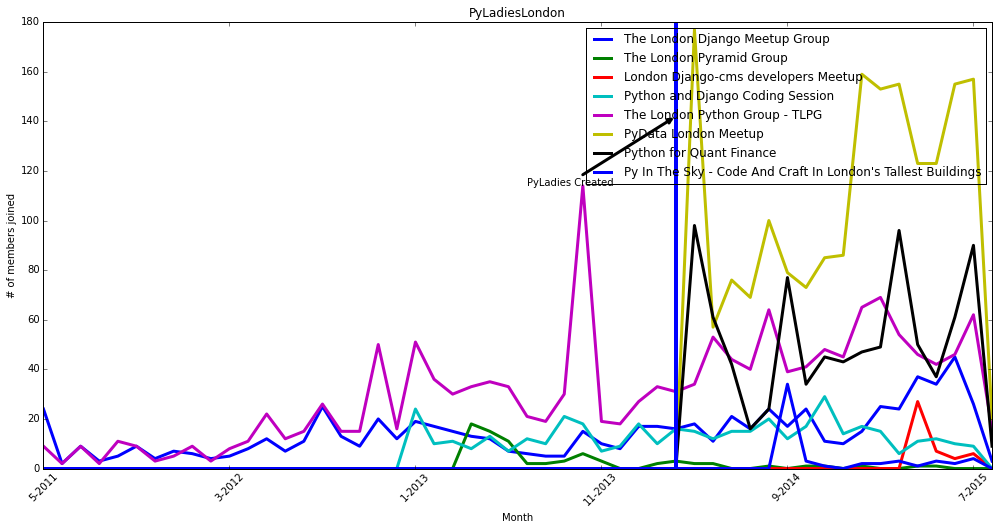

In [118]:
create_pyladies_graph(PYLADIES_GROUPS[22])

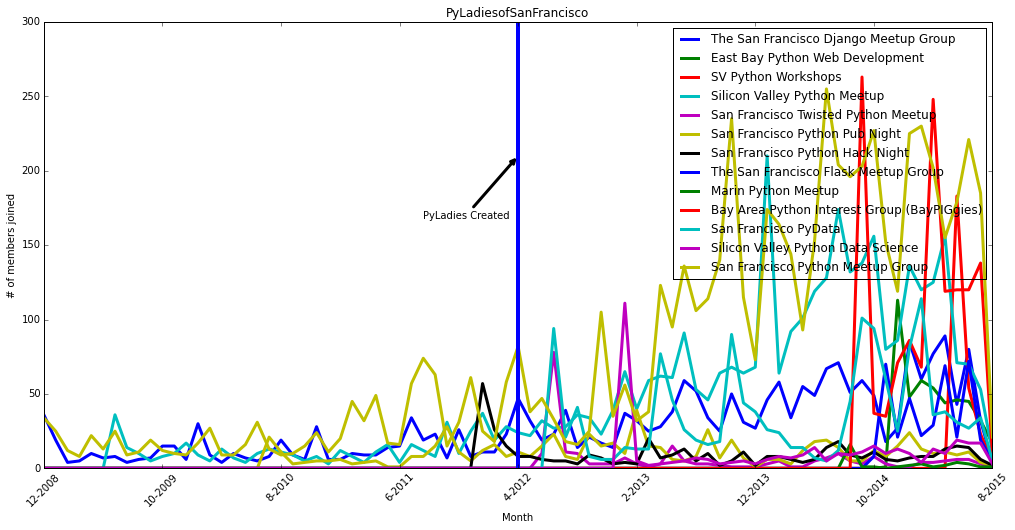

In [124]:
create_pyladies_graph(PYLADIES_GROUPS[28])

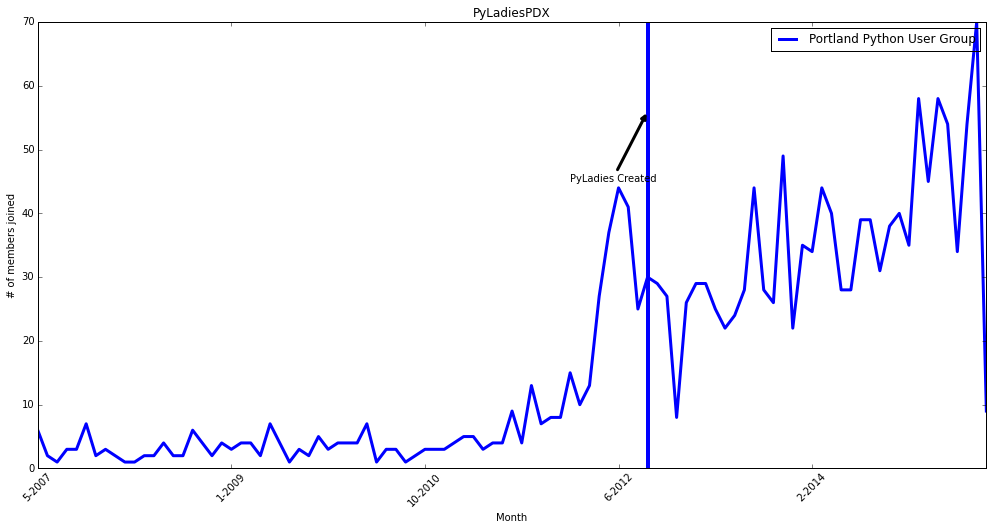

In [126]:
create_pyladies_graph(PYLADIES_GROUPS[30])

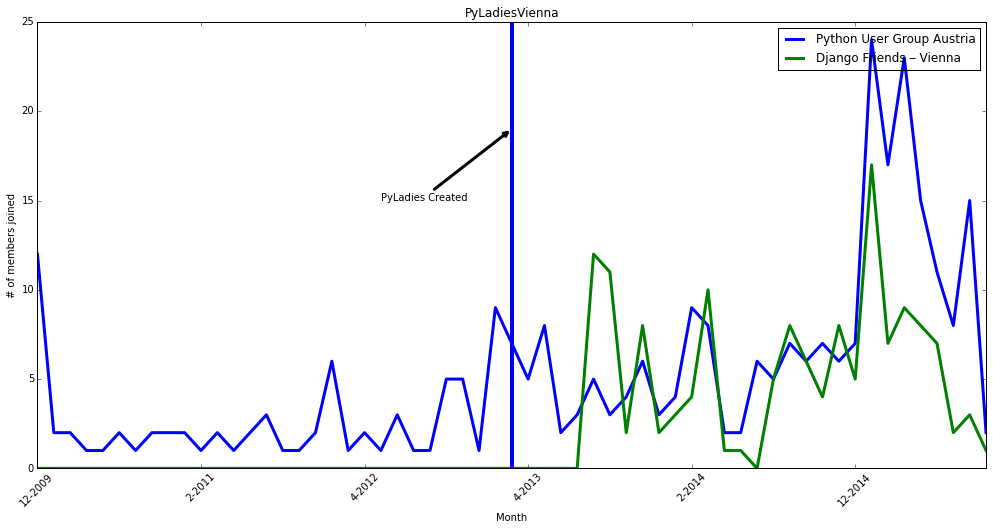

In [137]:
create_pyladies_graph(PYLADIES_GROUPS[39])